In [51]:
import cv2
import tensorflow as tf
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

TRAIN_DIR = '/Users/abhisheksrivastava/Desktop/Data/train'
TEST_DIR= '/Users/abhisheksrivastava/Desktop/Data/test'
IMG_SIZE=50
LR=1e-3
MODEL_NAME="dogsvscat-{}-{}.model".format(LR,"6conv-basic")


In [52]:
def label_image(img):
    word_label=img.split('.')[-3]
    if(word_label=='cat'): return [1,0]
    elif(word_label=='dog'): return [0,1]
def create_train_data():
    training_data=[]
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label=label_image(img)
        path=os.path.join(TRAIN_DIR,img)
        img=cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)       
    np.save('train_data.npy',training_data)
    return training_data


In [63]:
def process_test_data():
    testing_data=[]
    for img in tqdm(os.listdir(TEST_DIR)):
        path=os.path.join(TEST_DIR,img)
        img_num=img.split('.')[0]
        img=cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img),img])
    np.save('test_data.npy',testing_data)
    return testing_data


In [54]:
train_data=create_train_data()

100%|██████████| 25000/25000 [00:42<00:00, 590.47it/s]


In [55]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE,IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)


convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet,tensorboard_dir='log')

In [56]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model_loaded!')

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /Users/abhisheksrivastava/mlc/CovNet/dogsvscat-0.001-6conv-basic.model
model_loaded!


In [57]:
train = train_data[:-500]
test=train_data[-500:]
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]


test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]




In [58]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3829  | total loss: 0.52692 | time: 39.002s
| Adam | epoch: 005 | loss: 0.52692 - acc: 0.7360 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.52713 | time: 40.111s
| Adam | epoch: 005 | loss: 0.52713 - acc: 0.7327 | val_loss: 0.55901 - val_acc: 0.7280 -- iter: 24500/24500
--


In [59]:
model.save(MODEL_NAME)

INFO:tensorflow:/Users/abhisheksrivastava/mlc/CovNet/dogsvscat-0.001-6conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


100%|██████████| 12500/12500 [00:17<00:00, 724.50it/s] 


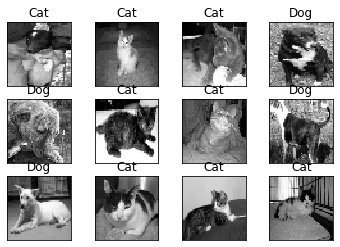

In [66]:
import matplotlib.pyplot as plt
test_data=process_test_data()
fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    img_num=data[1]
    img_data=data[0]
    y=fig.add_subplot(3,4,num+1)
    orig=img_data
    data=img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out=model.predict([data])[0]
    if np.argmax(model_out)==1 : str_label='Dog'
    else: str_label='Cat'
    
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [67]:
with open('submission-file.csv','w') as f:
    f.write('id,label\n')

In [69]:
with open('submission-file.csv','a') as f:
    for data in tqdm(test_data):
        img_num=data[1]
        img_data=data[0]
        y=fig.add_subplot(3,4,num+1)
        orig=img_data
        data=img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out=model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))

  0%|          | 0/12500 [00:00<?, ?it/s]/Users/abhisheksrivastava/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
100%|██████████| 12500/12500 [00:33<00:00, 374.88it/s]
